In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
%matplotlib inline

## Objective -- create a measure of a stock's forward return

Don't have exact price on day of conference call, but can build a simplified proxy that looks at the stock's return for the subsequent periods after a particular month.

Consistent with rest of analysis, going to build this so we can see absolute return and also return relative to two benchmarks of other stocks (equal_weighted and mkt cap weighted).

In [2]:
# File locations

# Tom's local machine
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

In [572]:
df = pd.read_csv(LIBRARY_PATH+"returns_data.csv")

In [573]:
# Create YearMth column to match the rest of our code
df["Day"], df["Month"], df["Year"] = df["MthEnd"].str.split("-").str
df["YearMth"] = df["Year"] + df["Month"]
df.drop(["MthEnd", "Day", "Month", "Year"], axis = 1, inplace = True)
df["MthFwdReturn"] = df["MthFwdReturn"] / 100
df["CodeYrMth"] = df["Code"] + df["YearMth"]
df.set_index("CodeYrMth", inplace = True)
df

,Code,MthFwdReturn,MthEndMCap,YearMth
CodeYrMth,,,,
AAPL201008,AAPL,0.167215,222087.1,201008
ABBV201008,ABBV,NaN,NaN,201008
ABT201008,ABT,0.058776,76182.4,201008
ACN201008,ACN,0.160929,25983.5,201008
AGN201008,AGN,-0.017646,5378.4,201008
AIG201008,AIG,0.152373,23682.9,201008
ALL201008,ALL,0.143116,14850.7,201008
AMGN201008,AMGN,0.079741,48920.5,201008
AMZN201008,AMZN,0.258191,55902.0,201008


In [574]:
df["MktCap_Wted_Return"] = df["MthFwdReturn"] * df["MthEndMCap"]

In [575]:
benchmarks = df[df["MthFwdReturn"].notnull()]\
             .groupby(df["YearMth"])["MthFwdReturn", "MktCap_Wted_Return"]\
             .sum()

In [576]:
valid_counts = mth_mkt_caps = pd.DataFrame(df[df["MthFwdReturn"].notnull()]\
                                                 .groupby(df["YearMth"])["Code"]\
                                                 .count())

In [577]:
mth_mkt_caps = pd.DataFrame(df[df["MthFwdReturn"].notnull()]\
                                                 .groupby(df["YearMth"])["MthEndMCap"]\
                                                 .sum())

In [578]:
benchmarks = pd.merge(benchmarks, mth_mkt_caps, left_index = True, right_index = True)
benchmarks = pd.merge(benchmarks, valid_counts, left_index = True, right_index = True)

In [579]:
benchmarks["EW_Benchmark"] = (benchmarks["MthFwdReturn"] / benchmarks["Code"])
benchmarks["MW_Benchmark"] = (benchmarks["MktCap_Wted_Return"] / benchmarks["MthEndMCap"])

In [580]:
benchmarks

,MthFwdReturn,MktCap_Wted_Return,MthEndMCap,Code,EW_Benchmark,MW_Benchmark
YearMth,,,,,,
201008,10.485521,5.754896e+05,6724489.7,119,0.088114,0.085581
201009,4.891137,2.851828e+05,7289356.1,119,0.041102,0.039123
201010,-0.148681,-3.902317e+04,7552268.1,119,-0.001249,-0.005167
201011,8.690692,5.153899e+05,7545887.3,120,0.072422,0.068301
201012,2.490882,1.799929e+05,8045258.1,120,0.020757,0.022373
201101,4.216111,2.437175e+05,8251239.9,120,0.035134,0.029537
201102,0.432040,-2.963609e+04,8478599.1,121,0.003571,-0.003495
201103,4.222126,2.368759e+05,8442518.2,121,0.034894,0.028057
201104,-0.956750,-1.277633e+05,8667765.2,121,-0.007907,-0.014740


In [581]:
df = df.merge(benchmarks[["EW_Benchmark", "MW_Benchmark"]], left_on = "YearMth",
             right_index = True, how = "left")
df
# benchmarks[["EW_Benchmark", "MW_Benchmark"]]

,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark
CodeYrMth,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581


In [582]:
def add_month(yrmonth, n):
    '''Add n months to a yearmonth field e.g. 201211 + 3 = 201302'''
    year = int(yrmonth[:4])
    month = int(yrmonth[4:])
    if month+n>12:
        year += 1
    month = ((month + n -1 ) % 12 ) + 1
    return str(year) + "{:02d}".format(month)

In [583]:
# Add Monthly Forward Return values for 2 through 6 months
# (note base month is +1 month return, so +1 month = 2 months ahead from month end)
for n in range(2, 7):
    master_vals = df[["Code", "YearMth"]]
    new_ym_field = "CYM_"+str(n)
    master_vals[new_ym_field] = master_vals["Code"]+master_vals["YearMth"].apply(add_month, n = n - 1)
    vals_wanted = pd.DataFrame(df["MthFwdReturn"])
    master_vals = master_vals.merge(vals_wanted, how = "left",
                      left_on = new_ym_field, right_index = True, suffixes = ("_0", "_1"))
    master_vals.rename(columns = {"MthFwdReturn" : "MFR_"+str(n)}, inplace = True)
    master_vals.drop(["Code", "YearMth", "CYM_"+str(n)], axis =1, inplace = True)
    df = df.join(master_vals, how = "left")
    
df
# master_vals
# vals_wanted

/Users/seddont/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark,MFR_2,MFR_3,MFR_4,MFR_5,MFR_6
CodeYrMth,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581,0.060722,0.033790,0.036670,0.051959,0.040935
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581,NaN,NaN,NaN,NaN,NaN
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581,-0.009483,-0.093726,0.030101,-0.048683,0.065102
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581,0.062712,-0.031089,0.119344,0.061456,0.000194
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581,0.102576,0.044802,0.059705,0.055566,0.026963
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581,0.074425,-0.017139,0.395495,-0.164058,-0.081537
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581,-0.033597,-0.038750,0.095156,-0.023212,0.020552
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581,0.037743,-0.078685,0.041943,0.003279,-0.068083
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581,0.052018,0.061551,0.026226,-0.057556,0.021516


In [584]:
pd.DataFrame(benchmarks.index.values)

,0
0,201008
1,201009
2,201010
3,201011
4,201012
5,201101
6,201102
7,201103
8,201104
9,201105


In [585]:
benchmarks[["EW_Benchmark", "MW_Benchmark"]]

,EW_Benchmark,MW_Benchmark
YearMth,,
201008,0.088114,0.085581
201009,0.041102,0.039123
201010,-0.001249,-0.005167
201011,0.072422,0.068301
201012,0.020757,0.022373
201101,0.035134,0.029537
201102,0.003571,-0.003495
201103,0.034894,0.028057
201104,-0.007907,-0.014740


In [586]:
# Add EW_benchmark and MW_benchmark for +1 through +5 months

for n in range(2, 7):
    master_vals = pd.DataFrame(benchmarks.index.values)
    master_vals.columns = ["YearMth"]
    new_ym_field = "YM_"+str(n)
    master_vals[new_ym_field] = master_vals["YearMth"].apply(add_month, n = n - 1)
    vals_wanted = pd.DataFrame(benchmarks[["EW_Benchmark", "MW_Benchmark"]])
    master_vals = master_vals.merge(vals_wanted, how = "left",
                      left_on = new_ym_field, right_index = True, suffixes = ("_0", "_1"))
    master_vals.rename(columns = {"EW_Benchmark" : "EWB_"+str(n), "MW_Benchmark" : "MWB_"+str(n)}, inplace = True)
    master_vals.set_index("YearMth", inplace = True)
    master_vals.drop([new_ym_field], axis =1, inplace = True)
    df = df.merge(master_vals, how = "left", left_on = "YearMth", right_index = True)
    
df
# master_vals
# vals_wanted

,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark,MFR_2,MFR_3,MFR_4,...,EWB_2,MWB_2,EWB_3,MWB_3,EWB_4,MWB_4,EWB_5,MWB_5,EWB_6,MWB_6
CodeYrMth,,,,,,,,,,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581,0.060722,0.033790,0.036670,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581,NaN,NaN,NaN,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581,-0.009483,-0.093726,0.030101,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581,0.062712,-0.031089,0.119344,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581,0.102576,0.044802,0.059705,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581,0.074425,-0.017139,0.395495,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581,-0.033597,-0.038750,0.095156,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581,0.037743,-0.078685,0.041943,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581,0.052018,0.061551,0.026226,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537


In [587]:
# Calculate compound returns

last_cmp_mfr = df["MthFwdReturn"]
last_cmp_ewb = df["EW_Benchmark"]
last_cmp_mwb = df["MW_Benchmark"]

for n in range(2, 7):
    last_cmp_mfr = (1 + last_cmp_mfr) * (df["MFR_"+str(n)] + 1) - 1
    df["Cmp_MFR_"+str(n)] = last_cmp_mfr
    
    last_cmp_ewb = (1 + last_cmp_ewb) * (df["EWB_"+str(n)] + 1) - 1
    df["Cmp_EWB_"+str(n)] = last_cmp_ewb
    
    last_cmp_mwb = (1 + last_cmp_mwb) * (df["MWB_"+str(n)] + 1) - 1
    df["Cmp_MWB_"+str(n)] = last_cmp_mwb
    
df

,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark,MFR_2,MFR_3,MFR_4,...,Cmp_MWB_3,Cmp_MFR_4,Cmp_EWB_4,Cmp_MWB_4,Cmp_MFR_5,Cmp_EWB_5,Cmp_MWB_5,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6
CodeYrMth,,,,,,,,,,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581,0.060722,0.033790,0.036670,...,0.122224,0.326861,0.213362,0.198873,0.395803,0.238548,0.225694,0.452940,0.282064,0.261898
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581,NaN,NaN,NaN,...,0.122224,NaN,0.213362,0.198873,NaN,0.238548,0.225694,NaN,0.282064,0.261898
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581,-0.009483,-0.093726,0.030101,...,0.122224,-0.020949,0.213362,0.198873,-0.068612,0.238548,0.225694,-0.007977,0.282064,0.261898
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581,0.062712,-0.031089,0.119344,...,0.122224,0.338039,0.213362,0.198873,0.420269,0.238548,0.225694,0.420545,0.282064,0.261898
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581,0.102576,0.044802,0.059705,...,0.122224,0.199211,0.213362,0.198873,0.265846,0.238548,0.225694,0.299977,0.282064,0.261898
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581,0.074425,-0.017139,0.395495,...,0.122224,0.698203,0.213362,0.198873,0.419599,0.238548,0.225694,0.303849,0.282064,0.261898
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581,-0.033597,-0.038750,0.095156,...,0.122224,0.162950,0.213362,0.198873,0.135955,0.238548,0.225694,0.159301,0.282064,0.261898
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581,0.037743,-0.078685,0.041943,...,0.122224,0.075627,0.213362,0.198873,0.079154,0.238548,0.225694,0.005682,0.282064,0.261898
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581,0.052018,0.061551,0.026226,...,0.122224,0.441961,0.213362,0.198873,0.358968,0.238548,0.225694,0.388207,0.282064,0.261898


In [588]:
# clean up intermediate columns we don't really need
# Just want compound 1, 3, 6 month values

drop_cols = []
for n in range(2, 7):
    drop_cols.extend(["MFR_"+str(n),"EWB_"+str(n),"MWB_"+str(n)])
    
for n in [2,4,5]:
    drop_cols.extend(["Cmp_MFR_"+str(n),"Cmp_EWB_"+str(n),"Cmp_MWB_"+str(n)])
    
drop_cols.extend(["MthEndMCap", "MktCap_Wted_Return"])
    
df.drop(drop_cols, axis = 1, inplace = True)

df
#     drop_cols.append("EWB_"+str(n))
# for m in [1,3,4]:
#     for f in ["MFR, "]
# df.drop([""])

# drop_cols

,Code,MthFwdReturn,YearMth,EW_Benchmark,MW_Benchmark,Cmp_MFR_3,Cmp_EWB_3,Cmp_MWB_3,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6
CodeYrMth,,,,,,,,,,,
AAPL201008,AAPL,0.167215,201008,0.088114,0.085581,0.279926,0.131422,0.122224,0.452940,0.282064,0.261898
ABBV201008,ABBV,NaN,201008,0.088114,0.085581,NaN,0.131422,0.122224,NaN,0.282064,0.261898
ABT201008,ABT,0.058776,201008,0.088114,0.085581,-0.049558,0.131422,0.122224,-0.007977,0.282064,0.261898
ACN201008,ACN,0.160929,201008,0.088114,0.085581,0.195378,0.131422,0.122224,0.420545,0.282064,0.261898
AGN201008,AGN,-0.017646,201008,0.088114,0.085581,0.131646,0.131422,0.122224,0.299977,0.282064,0.261898
AIG201008,AIG,0.152373,201008,0.088114,0.085581,0.216918,0.131422,0.122224,0.303849,0.282064,0.261898
ALL201008,ALL,0.143116,201008,0.088114,0.085581,0.061903,0.131422,0.122224,0.159301,0.282064,0.261898
AMGN201008,AMGN,0.079741,201008,0.088114,0.085581,0.032328,0.131422,0.122224,0.005682,0.282064,0.261898
AMZN201008,AMZN,0.258191,201008,0.088114,0.085581,0.405111,0.131422,0.122224,0.388207,0.282064,0.261898


In [589]:
# rename 1 month columns for consistency
df.rename(columns = {"MthFwdReturn" : "Cmp_MFR_1", 
                     "EW_Benchmark" : "Cmp_EWB_1",
                     "MW_Benchmark" : "Cmp_MWB_1"}, inplace = True)

In [590]:
# calculate compund return relative to benchmark
for n in [1,3,6]:
    df["alpha_ew_"+str(n)] = df["Cmp_MFR_"+str(n)] - df["Cmp_EWB_"+str(n)]
    df["alpha_mw_"+str(n)] = df["Cmp_MFR_"+str(n)] - df["Cmp_MWB_"+str(n)]

In [591]:
df

,Code,Cmp_MFR_1,YearMth,Cmp_EWB_1,Cmp_MWB_1,Cmp_MFR_3,Cmp_EWB_3,Cmp_MWB_3,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6,alpha_ew_1,alpha_mw_1,alpha_ew_3,alpha_mw_3,alpha_ew_6,alpha_mw_6
CodeYrMth,,,,,,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,201008,0.088114,0.085581,0.279926,0.131422,0.122224,0.452940,0.282064,0.261898,0.079101,0.081634,0.148504,0.157702,0.170876,0.191042
ABBV201008,ABBV,NaN,201008,0.088114,0.085581,NaN,0.131422,0.122224,NaN,0.282064,0.261898,NaN,NaN,NaN,NaN,NaN,NaN
ABT201008,ABT,0.058776,201008,0.088114,0.085581,-0.049558,0.131422,0.122224,-0.007977,0.282064,0.261898,-0.029338,-0.026805,-0.180980,-0.171782,-0.290041,-0.269875
ACN201008,ACN,0.160929,201008,0.088114,0.085581,0.195378,0.131422,0.122224,0.420545,0.282064,0.261898,0.072815,0.075348,0.063956,0.073154,0.138481,0.158647
AGN201008,AGN,-0.017646,201008,0.088114,0.085581,0.131646,0.131422,0.122224,0.299977,0.282064,0.261898,-0.105760,-0.103227,0.000224,0.009422,0.017913,0.038079
AIG201008,AIG,0.152373,201008,0.088114,0.085581,0.216918,0.131422,0.122224,0.303849,0.282064,0.261898,0.064259,0.066792,0.085496,0.094694,0.021785,0.041951
ALL201008,ALL,0.143116,201008,0.088114,0.085581,0.061903,0.131422,0.122224,0.159301,0.282064,0.261898,0.055002,0.057535,-0.069519,-0.060321,-0.122762,-0.102596
AMGN201008,AMGN,0.079741,201008,0.088114,0.085581,0.032328,0.131422,0.122224,0.005682,0.282064,0.261898,-0.008373,-0.005840,-0.099094,-0.089896,-0.276382,-0.256216
AMZN201008,AMZN,0.258191,201008,0.088114,0.085581,0.405111,0.131422,0.122224,0.388207,0.282064,0.261898,0.170077,0.172610,0.273689,0.282887,0.106144,0.126310


In [594]:
model_dir = LIBRARY_PATH = "saved_models/topic20_minlength20_base"

with open(model_dir+"/hell_sims.txt", "r") as f:
    scores = json.loads(f.read())

In [595]:
scores

{u'ETR_20110802': {u'13': 0.26174575105958214,
  u'14': 0.6851481491477092,
  u'22': 0.5034241071453505,
  u'26': 0.5214069514009948,
  u'4': 0.24360511062698342,
  u'6': 0.6704420410358952,
  u'8': 0.5705146500946645},
 u'CELG_20160728': {u'1': 0.6032902699300821,
  u'2': 0.5491252124388154,
  u'3': 0.3392722168949353,
  u'7': 0.6247031462075436,
  u'8': 0.46257337213930866},
 u'MO_20151029': {u'0': 0.6514741172488995,
  u'1': 0.25039768709124566,
  u'12': 0.2982029778600752,
  u'15': 0.6035120129965542,
  u'16': 0.2614093174431971,
  u'18': 0.6389557127602249,
  u'19': 0.45095709617358265,
  u'2': 0.5168266077323852,
  u'20': 0.49356002388919323,
  u'5': 0.32728533015219285,
  u'6': 0.5050836781046982,
  u'8': 0.37429106697198056,
  u'9': 0.43186968364208594},
 u'BAC_20160718': {u'11': 0.4728999000140742,
  u'15': 0.4820048155699724,
  u'17': 0.45866531961074275,
  u'2': 0.40882334873605747,
  u'22': 0.2826308209036495,
  u'23': 0.5796127952521117,
  u'24': 0.5178743209111099,
  u'28

In [608]:
# Take a scoring file and turn into a pandas dataframe for joining to the point returns
#
# Scoring file is a dict of dicts -- {"transcript_file": {q_num: score, q_num:score...}, ...}
#
# transcript_file is of form CODE_YEARMTHDAY e.g. ETR_20110802

cym = []
avg_scores = []

for transcript in scores:
    code, long_date = transcript.split("_")
    yearmth = long_date[:6]
    cym.append(code + yearmth)
    avg_scores.append(np.mean([scores[transcript][q] for q in scores[transcript]]))

d = {"CodeYrMth": cym, "Score": avg_scores}
sf = pd.DataFrame(data = d)
sf.set_index("CodeYrMth", inplace = True)
sf

,Score
CodeYrMth,
ETR201108,0.493755
CELG201607,0.515793
MO201510,0.446448
BAC201607,0.463794
RTN201310,0.429066
BA201604,0.489758
XRX201404,0.452931
CMCSA201704,0.420229
AVP201611,0.451643


In [609]:
# Join point return data to scores
sf = sf.join(df, how = "left")
sf

,Score,Code,Cmp_MFR_1,YearMth,Cmp_EWB_1,Cmp_MWB_1,Cmp_MFR_3,Cmp_EWB_3,Cmp_MWB_3,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6,alpha_ew_1,alpha_mw_1,alpha_ew_3,alpha_mw_3,alpha_ew_6,alpha_mw_6
CodeYrMth,,,,,,,,,,,,,,,,,,
ETR201108,0.493755,ETR,0.016562,201108,-0.077519,-0.060493,0.091974,0.032637,0.033644,0.046637,0.140967,0.145012,0.094081,0.077055,0.059337,0.058330,-0.094330,-0.098375
CELG201607,0.515793,CELG,-0.048578,201607,0.005308,0.002329,-0.089224,-0.004252,-0.009440,0.035297,0.085231,0.060120,-0.053886,-0.050907,-0.084973,-0.079784,-0.049933,-0.024823
MO201510,0.446448,MO,-0.047462,201510,-0.000487,0.004029,0.020467,-0.077620,-0.052082,0.056726,0.026124,0.003074,-0.046975,-0.051491,0.098088,0.072549,0.030603,0.053652
BAC201607,0.463794,BAC,0.119048,201607,0.005308,0.002329,0.144008,-0.004252,-0.009440,0.575293,0.085231,0.060120,0.113740,0.116719,0.148260,0.153449,0.490063,0.515174
RTN201310,0.429066,RTN,0.076606,201310,0.026627,0.032584,0.161203,0.024806,0.019274,0.173353,0.090059,0.079935,0.049979,0.044022,0.136396,0.141929,0.083294,0.093418
BA201604,0.489758,BA,-0.056500,201604,0.005126,0.017654,-0.000331,0.047544,0.058312,0.074040,0.043090,0.048321,-0.061626,-0.074154,-0.047875,-0.058643,0.030950,0.025719
XRX201404,0.452931,XRX,0.021505,201404,0.031861,0.024821,0.102328,0.044657,0.034571,0.109214,0.093811,0.085956,-0.010356,-0.003316,0.057671,0.067757,0.015403,0.023258
CMCSA201704,0.420229,CMCSA,0.063792,201704,-0.001518,0.012472,0.036328,0.034059,0.038451,-0.073116,0.073126,0.091864,0.065310,0.051320,0.002268,-0.002123,-0.146242,-0.164980
AVP201611,0.451643,AVP,-0.061453,201611,0.015320,0.022895,-0.180633,0.076489,0.085788,-0.366853,0.077331,0.116280,-0.076773,-0.084348,-0.257122,-0.266422,-0.444184,-0.483133


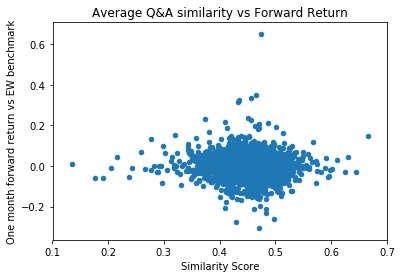

In [614]:
# quick visualization
sf.plot(kind = "scatter", x = "Score", y = "alpha_ew_1")
plt.title("Average Q&A similarity vs Forward Return")
plt.xlabel("Similarity Score")
plt.ylabel("One month forward return vs EW benchmark")

In [624]:
# Run single variable OLS

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

results = smf.ols("alpha_ew_1 ~ Score", data = sf).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:             alpha_ew_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5518
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.458
Time:                        15:28:37   Log-Likelihood:                 4397.2
No. Observations:                2899   AIC:                            -8790.
Df Residuals:                    2897   BIC:                            -8778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0081      0.010      0.769      0.4

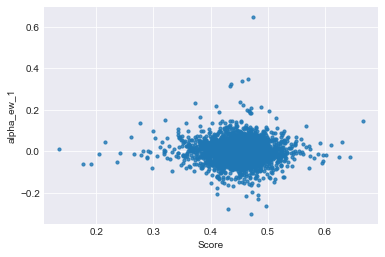

In [638]:
sns.set_style("darkgrid")
sns.regplot(x = "Score", y = "alpha_ew_1", data = sf, fit_reg = False, 
            scatter_kws={"s": 10}, lowess = True)

In [635]:
# Try a model more robust to outliers...

results = smf.rlm("alpha_ew_1 ~ Score", data = sf).fit()
print results.summary()

                    Robust linear Model Regression Results                    
Dep. Variable:             alpha_ew_1   No. Observations:                 2899
Model:                            RLM   Df Residuals:                     2897
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 12 Dec 2017                                         
Time:                        15:37:22                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0047      0.009      0.528      0.5

## Using Daily Returns data

Want to build similar dataset but using more precise daily data, as the longer term measures may contain too much market noise and the month end values may be up to 30 days out of date for a conf call.  

Won't have return measures for literally every day because market closed on weekends and holidays.  But would expect all the conf calls to happen on days that market was open.  So rather than working from literal calendar day differences will work from an offset of a number of business days.

Want to create two measures:

- +20 business day forward return from the day of the conference call - roughly 4 weeks after
- -1 day before rbefore the conference call i.e. captures the immediate market reaction to the call on the day

Only going to use EW benchmark approach rather than Mkt Cap wted benchmark -- not much difference seen above anyway, and simpler.

In [154]:
df = pd.read_csv(LIBRARY_PATH+"returns_data_daily.csv")

In [155]:
# Create YearMth column to match the rest of our code
df["Day"], df["Month"], df["Year"] = df["Date"].str.split("-").str
df["YearMthDay"] = df["Year"] + df["Month"] + df["Day"]
df.drop(["Date", "Month", "Year"], axis = 1, inplace = True)
df["DayFwdReturn"] = df["DayFwdReturn"] / 100 + 1
df["CodeYrMthDay"] = df["Code"] + df["YearMthDay"]
df.set_index("CodeYrMthDay", inplace = True)
df.sort_index(ascending = True, inplace = True)
df

,Code,DayFwdReturn,Weight,Day,YearMthDay
CodeYrMthDay,,,,,
0848680D20091214,0848680D,0.975000,1,14,20091214
0848680D20091215,0848680D,1.007692,1,15,20091215
0848680D20091216,0848680D,0.959288,1,16,20091216
0848680D20091217,0848680D,0.986737,1,17,20091217
0848680D20091218,0848680D,1.013441,1,18,20091218
0848680D20091221,0848680D,1.015915,1,21,20091221
0848680D20091222,0848680D,0.966057,1,22,20091222
0848680D20091223,0848680D,1.008108,1,23,20091223
0848680D20091224,0848680D,0.978552,1,24,20091224


In [156]:
# Initialize empty dataframe
cum_rets = pd.DataFrame(columns = ["CodeYrMthDay", "CumFwdReturn"])
cum_rets.set_index("CodeYrMthDay", inplace = True)

for code in sorted(set(df["Code"])):

    # Calc cumulative product of daily returns for this code
    cum_code = pd.DataFrame(df[df["Code"] == code]["DayFwdReturn"].cumprod())
    cum_code.columns = ["CumFwdReturn"]

    # Append to complete frame
    cum_rets = cum_rets.append(cum_code)

# Append to main dataframe
df = df.merge(cum_rets, how = "left", left_index = True, right_index = True)
df

,Code,DayFwdReturn,Weight,Day,YearMthDay,CumFwdReturn
CodeYrMthDay,,,,,,
0848680D20091214,0848680D,0.975000,1,14,20091214,0.975000
0848680D20091215,0848680D,1.007692,1,15,20091215,0.982500
0848680D20091216,0848680D,0.959288,1,16,20091216,0.942500
0848680D20091217,0848680D,0.986737,1,17,20091217,0.930000
0848680D20091218,0848680D,1.013441,1,18,20091218,0.942500
0848680D20091221,0848680D,1.015915,1,21,20091221,0.957500
0848680D20091222,0848680D,0.966057,1,22,20091222,0.924999
0848680D20091223,0848680D,1.008108,1,23,20091223,0.932499
0848680D20091224,0848680D,0.978552,1,24,20091224,0.912499


In [157]:
# Get a list of all the days the market was open
open_days = sorted(set(df["YearMthDay"]))

# Create list of preceding open day
open_preceding = [""]
for i in range(1, len(open_days)):
    open_preceding.append(open_days[i-1])
    
# Create list of +20 days
open_plus20 = []
for i in range(0, len(open_days) - 20):
    open_plus20.append(open_days[i+20])
for i in range(20):
    open_plus20.append("")
    
# Create dataframe mapping the three
day_map = pd.DataFrame({"YearMthDay": open_days, "Preceding": open_preceding,
                        "Plus20": open_plus20})
day_map.set_index("YearMthDay", inplace = True)

In [158]:
day_map

,Plus20,Preceding
YearMthDay,,
20091214,20100113,
20091215,20100114,20091214
20091216,20100115,20091215
20091217,20100119,20091216
20091218,20100120,20091217
20091221,20100121,20091218
20091222,20100122,20091221
20091223,20100125,20091222
20091224,20100126,20091223


In [159]:
# Append day_map to main dataframe
df = df.merge(day_map, how = "left", left_on = "YearMthDay", right_index = True)

In [160]:
df["CodePlus20"] = df["Code"] + df["Plus20"]
df["CodePreceding"] = df["Code"] + df["Preceding"]
df

,Code,DayFwdReturn,Weight,Day,YearMthDay,CumFwdReturn,Plus20,Preceding,CodePlus20,CodePreceding
CodeYrMthDay,,,,,,,,,,
0848680D20091214,0848680D,0.975000,1,14,20091214,0.975000,20100113,,0848680D20100113,0848680D
0848680D20091215,0848680D,1.007692,1,15,20091215,0.982500,20100114,20091214,0848680D20100114,0848680D20091214
0848680D20091216,0848680D,0.959288,1,16,20091216,0.942500,20100115,20091215,0848680D20100115,0848680D20091215
0848680D20091217,0848680D,0.986737,1,17,20091217,0.930000,20100119,20091216,0848680D20100119,0848680D20091216
0848680D20091218,0848680D,1.013441,1,18,20091218,0.942500,20100120,20091217,0848680D20100120,0848680D20091217
0848680D20091221,0848680D,1.015915,1,21,20091221,0.957500,20100121,20091218,0848680D20100121,0848680D20091218
0848680D20091222,0848680D,0.966057,1,22,20091222,0.924999,20100122,20091221,0848680D20100122,0848680D20091221
0848680D20091223,0848680D,1.008108,1,23,20091223,0.932499,20100125,20091222,0848680D20100125,0848680D20091222
0848680D20091224,0848680D,0.978552,1,24,20091224,0.912499,20100126,20091223,0848680D20100126,0848680D20091223


In [161]:
# Create column for one day return i.e. market reaction
pre_vals = df[["DayFwdReturn"]]
pre_vals.columns = ["DFR_Pre"]
pre_vals["DFR_Pre"] = pre_vals["DFR_Pre"] - 1
df =df.merge(pre_vals, how = "left", left_on = "CodePreceding", right_index = True)
df

/Users/seddont/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Code,DayFwdReturn,Weight,Day,YearMthDay,CumFwdReturn,Plus20,Preceding,CodePlus20,CodePreceding,DFR_Pre
CodeYrMthDay,,,,,,,,,,,
0848680D20091214,0848680D,0.975000,1,14,20091214,0.975000,20100113,,0848680D20100113,0848680D,NaN
0848680D20091215,0848680D,1.007692,1,15,20091215,0.982500,20100114,20091214,0848680D20100114,0848680D20091214,-0.025000
0848680D20091216,0848680D,0.959288,1,16,20091216,0.942500,20100115,20091215,0848680D20100115,0848680D20091215,0.007692
0848680D20091217,0848680D,0.986737,1,17,20091217,0.930000,20100119,20091216,0848680D20100119,0848680D20091216,-0.040712
0848680D20091218,0848680D,1.013441,1,18,20091218,0.942500,20100120,20091217,0848680D20100120,0848680D20091217,-0.013263
0848680D20091221,0848680D,1.015915,1,21,20091221,0.957500,20100121,20091218,0848680D20100121,0848680D20091218,0.013441
0848680D20091222,0848680D,0.966057,1,22,20091222,0.924999,20100122,20091221,0848680D20100122,0848680D20091221,0.015915
0848680D20091223,0848680D,1.008108,1,23,20091223,0.932499,20100125,20091222,0848680D20100125,0848680D20091222,-0.033943
0848680D20091224,0848680D,0.978552,1,24,20091224,0.912499,20100126,20091223,0848680D20100126,0848680D20091223,0.008108


In [162]:
plus20_vals = df[["CumFwdReturn"]]
plus20_vals.columns = ["Cum_plus20"]
df = df =df.merge(plus20_vals, how = "left", left_on = "CodePlus20", right_index = True)
df["DFR_plus20"] = df["Cum_plus20"] / df["CumFwdReturn"] - 1

In [163]:
df[df["Code"] == "AAPL"]

,Code,DayFwdReturn,Weight,Day,YearMthDay,CumFwdReturn,Plus20,Preceding,CodePlus20,CodePreceding,DFR_Pre,Cum_plus20,DFR_plus20
CodeYrMthDay,,,,,,,,,,,,,
AAPL20091214,AAPL,0.985735,1,14,20091214,0.985735,20100113,,AAPL20100113,AAPL,NaN,1.063202,0.078588
AAPL20091215,AAPL,1.004429,1,15,20091215,0.990101,20100114,20091214,AAPL20100114,AAPL20091214,-0.014265,1.045434,0.055886
AAPL20091216,AAPL,0.983746,1,16,20091216,0.974008,20100115,20091215,AAPL20100115,AAPL20091215,0.004429,1.091682,0.120814
AAPL20091217,AAPL,1.018607,1,17,20091217,0.992131,20100119,20091216,AAPL20100119,AAPL20091216,-0.016254,1.074852,0.083377
AAPL20091218,AAPL,1.014327,1,18,20091218,1.006345,20100120,20091217,AAPL20100120,AAPL20091217,0.018607,1.056307,0.049647
AAPL20091221,AAPL,1.010745,1,21,20091221,1.017159,20100121,20091218,AAPL20100121,AAPL20091218,0.014327,1.003906,-0.013029
AAPL20091222,AAPL,1.008684,1,22,20091222,1.025992,20100122,20091221,AAPL20100122,AAPL20091221,0.010745,1.030939,0.004822
AAPL20091223,AAPL,1.034339,1,23,20091223,1.061223,20100125,20091222,AAPL20100125,AAPL20091222,0.008684,1.045483,-0.014832
AAPL20091224,AAPL,1.012294,1,24,20091224,1.074270,20100126,20091223,AAPL20100126,AAPL20091223,0.034339,1.055353,-0.017609


In [164]:
# Create benchmarks and append to main dataframe

benchmarks = df.groupby(df["YearMthDay"])["DFR_Pre", "DFR_plus20"].mean()
benchmarks.columns = ["EW_DFR_Pre", "EW_DFR_plus20"]
benchmarks

,EW_DFR_Pre,EW_DFR_plus20
YearMthDay,,
20091214,NaN,0.036512
20091215,-0.004934,0.026137
20091216,0.000885,0.052915
20091217,-0.013079,0.035879
20091218,0.006498,0.007197
20091221,0.010452,-0.019699
20091222,0.002914,-0.017537
20091223,0.002235,-0.026436
20091224,0.005036,-0.021531


In [166]:
df = df.merge(benchmarks, how = "left", left_on = "YearMthDay", right_index = True)
df["alpha_ew_pre"] = (1 + df["DFR_Pre"]) / (1 + df["EW_DFR_Pre"]) - 1
df["alpha_ew_plus20"] = (1 + df["DFR_plus20"]) / (1 + df["EW_DFR_plus20"]) - 1
df

,Code,DayFwdReturn,Weight,Day,YearMthDay,CumFwdReturn,Plus20,Preceding,CodePlus20,CodePreceding,DFR_Pre,Cum_plus20,DFR_plus20,EW_DFR_Pre,EW_DFR_plus20,alpha_ew_pre,alpha_ew_plus20
CodeYrMthDay,,,,,,,,,,,,,,,,,
0848680D20091214,0848680D,0.975000,1,14,20091214,0.975000,20100113,,0848680D20100113,0848680D,NaN,0.922499,-0.053847,NaN,0.036512,NaN,-0.087177
0848680D20091215,0848680D,1.007692,1,15,20091215,0.982500,20100114,20091214,0848680D20100114,0848680D20091214,-0.025000,0.954998,-0.027991,-0.004934,0.026137,-0.020165,-0.052750
0848680D20091216,0848680D,0.959288,1,16,20091216,0.942500,20100115,20091215,0848680D20100115,0848680D20091215,0.007692,0.919999,-0.023874,0.000885,0.052915,0.006801,-0.072931
0848680D20091217,0848680D,0.986737,1,17,20091217,0.930000,20100119,20091216,0848680D20100119,0848680D20091216,-0.040712,0.887499,-0.045700,-0.013079,0.035879,-0.027999,-0.078754
0848680D20091218,0848680D,1.013441,1,18,20091218,0.942500,20100120,20091217,0848680D20100120,0848680D20091217,-0.013263,0.864999,-0.082229,0.006498,0.007197,-0.019634,-0.088787
0848680D20091221,0848680D,1.015915,1,21,20091221,0.957500,20100121,20091218,0848680D20100121,0848680D20091218,0.013441,0.842499,-0.120106,0.010452,-0.019699,0.002958,-0.102425
0848680D20091222,0848680D,0.966057,1,22,20091222,0.924999,20100122,20091221,0848680D20100122,0848680D20091221,0.015915,0.859999,-0.070271,0.002914,-0.017537,0.012963,-0.053675
0848680D20091223,0848680D,1.008108,1,23,20091223,0.932499,20100125,20091222,0848680D20100125,0848680D20091222,-0.033943,0.852499,-0.085791,0.002235,-0.026436,-0.036097,-0.060967
0848680D20091224,0848680D,0.978552,1,24,20091224,0.912499,20100126,20091223,0848680D20100126,0848680D20091223,0.008108,0.872499,-0.043836,0.005036,-0.021531,0.003056,-0.022796


In [170]:
# Drop unwanted columns
drop_cols = ["Weight", "Day", "CumFwdReturn", "Plus20", "Preceding", "CodePlus20",
             "CodePreceding", "Cum_plus20"]
df.drop(drop_cols, inplace=True, axis = 1)

## Take a look at this with one of the model runs

In [167]:
model_dir = LIBRARY_PATH = "saved_models/topic100_minlength20_base"

with open(model_dir+"/hell_sims.txt", "r") as f:
    scores = json.loads(f.read())

In [168]:
scores

{u'ETR_20110802': {u'13': 0.3087786582778658,
  u'14': 0.6592185279076562,
  u'22': 0.5260008086955397,
  u'26': 0.5783874010168475,
  u'4': 0.47207966262453327,
  u'6': 0.6153501279749961,
  u'8': 0.5373833204201237},
 u'CELG_20160728': {u'1': 0.5521525938745958,
  u'2': 0.5657274864808653,
  u'3': 0.5557086062833005,
  u'7': 0.560493408262737,
  u'8': 0.5472481131816958},
 u'MO_20151029': {u'0': 0.6539889931196338,
  u'1': 0.7025273842298171,
  u'12': 0.5256370010493586,
  u'15': 0.6529442619237681,
  u'16': 0.4867462198321332,
  u'18': 0.5040059719593202,
  u'19': 0.539784362493112,
  u'2': 0.4939371030404441,
  u'20': 0.6115499126521077,
  u'5': 0.5740701840562087,
  u'6': 0.4580405962092104,
  u'8': 0.439704788754369,
  u'9': 0.5340269056402791},
 u'BAC_20160718': {u'11': 0.6317231740073354,
  u'15': 0.5720702906584411,
  u'17': 0.4841451692013608,
  u'2': 0.5126260328009683,
  u'22': 0.4515794608959534,
  u'23': 0.5498232814575086,
  u'24': 0.5102769532894352,
  u'28': 0.50979093

In [169]:
# Take a scoring file and turn into a pandas dataframe for joining to the point returns
#
# Scoring file is a dict of dicts -- {"transcript_file": {q_num: score, q_num:score...}, ...}
#
# transcript_file is of form CODE_YEARMTHDAY e.g. ETR_20110802

cym = []
avg_scores = []

for transcript in scores:
    code, long_date = transcript.split("_")
    cym.append(code+long_date)
    avg_scores.append(np.mean([scores[transcript][q] for q in scores[transcript]]))

d = {"CodeYrMthDay": cym, "Score": avg_scores}
sf = pd.DataFrame(data = d)
sf.set_index("CodeYrMthDay", inplace = True)
sf

,Score
CodeYrMthDay,
ETR20110802,0.528171
CELG20160728,0.556266
MO20151029,0.552074
BAC20160718,0.537761
RTN20131024,0.539598
BA20160427,0.527793
XRX20140422,0.507990
CMCSA20170427,0.534535
AVP20161103,0.568243


In [172]:
# Join point return data to scores
sf = sf.join(df, how = "left")
sf

,Score,Code,DayFwdReturn,YearMthDay,DFR_Pre,DFR_plus20,EW_DFR_Pre,EW_DFR_plus20,alpha_ew_pre,alpha_ew_plus20
CodeYrMthDay,,,,,,,,,,
ETR20110802,0.528171,ETR,0.997241,20110802,-0.017467,0.015739,-0.026240,-0.036032,0.009010,0.053707
CELG20160728,0.556266,CELG,1.008359,20160728,0.029137,-0.030305,0.000063,0.004037,0.029072,-0.034204
MO20151029,0.552074,MO,0.982773,20151029,0.001465,-0.047462,-0.001307,-0.000487,0.002776,-0.046998
BAC20160718,0.537761,BAC,1.010631,20160718,0.032943,0.063817,0.002990,0.012257,0.029864,0.050936
RTN20131024,0.539598,RTN,1.024078,20131024,-0.005224,0.092546,0.002824,0.021915,-0.008026,0.069116
BA20160427,0.527793,BA,0.983367,20160427,0.028820,-0.032865,0.006483,-0.002237,0.022193,-0.030697
XRX20140422,0.507990,XRX,1.031924,20140422,0.010462,-0.009197,0.003536,0.008766,0.006901,-0.017807
CMCSA20170427,0.534535,CMCSA,0.989896,20170427,0.020624,0.043891,-0.000186,-0.000630,0.020814,0.044549
AVP20161103,0.568243,AVP,0.951923,20161103,-0.026521,-0.116163,-0.002128,0.070559,-0.024445,-0.174415


In [173]:
# Run single variable OLS

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

results = smf.ols("alpha_ew_pre ~ Score", data = sf).fit()
print results.summary()

/Users/seddont/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:           alpha_ew_pre   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2179
Date:                Wed, 13 Dec 2017   Prob (F-statistic):              0.641
Time:                        16:39:51   Log-Likelihood:                 5991.6
No. Observations:                2905   AIC:                        -1.198e+04
Df Residuals:                    2903   BIC:                        -1.197e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0049      0.010     -0.482      0.6

In [174]:
results = smf.ols("alpha_ew_plus20 ~ Score", data = sf).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:        alpha_ew_plus20   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8808
Date:                Wed, 13 Dec 2017   Prob (F-statistic):              0.348
Time:                        16:40:14   Log-Likelihood:                 4469.5
No. Observations:                2905   AIC:                            -8935.
Df Residuals:                    2903   BIC:                            -8923.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0157      0.017     -0.919      0.3

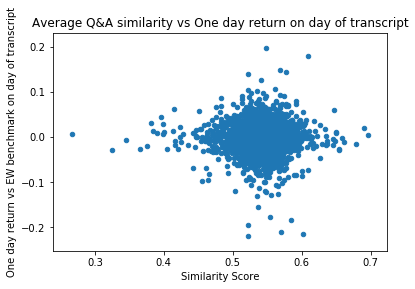

In [175]:
# quick visualization
sf.plot(kind = "scatter", x = "Score", y = "alpha_ew_pre")
plt.title("Average Q&A similarity vs One day return on day of transcript")
plt.xlabel("Similarity Score")
plt.ylabel("One day return vs EW benchmark on day of transcript")